In [41]:
from google.colab import files
import os

print("ЗАГРУЗКА CSV ФАЙЛОВ")

uploaded = files.upload()

print("\nЗагруженные файлы:")
for filename in uploaded.keys():
    print(f"  ├─ {filename}")


ЗАГРУЗКА CSV ФАЙЛОВ


Saving issues.csv to issues (1).csv
Saving resolutions.csv to resolutions (1).csv

Загруженные файлы:
  ├─ issues (1).csv
  ├─ resolutions (1).csv


In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

print("ИМПОРТ БИБЛИОТЕК И НАСТРОЙКА СТИЛЯ")

print("\nВсе библиотеки загружены")

%matplotlib inline
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9

print("Стиль для графиков готов")

ИМПОРТ БИБЛИОТЕК И НАСТРОЙКА СТИЛЯ

Все библиотеки загружены
Стиль для графиков готов


In [45]:
print("ЗАГРУЗКА И ОЧИСТКА ДАННЫХ")

# Загрузка CSV файлов
issues = pd.read_csv('issues.csv', sep=';')
resolutions = pd.read_csv('resolutions.csv', sep=';')

print(f"\nИсходные данные:")
print(f"   ├─ Issues: {len(issues):,} записей")
print(f"   └─ Resolutions: {len(resolutions):,} записей")

# Очистка: исключаем epoch аномалии (значения < 1 триллиона миллисекунд)
issues_clean = issues[issues['created'] > 1000000000000].copy()

# Конвертируем timestamp (миллисекунды) в datetime
issues_clean['created_dt'] = pd.to_datetime(issues_clean['created'] / 1000, unit='s')
issues_clean['resolved_dt'] = pd.to_datetime(issues_clean['resolved'] / 1000, unit='s', errors='coerce')

# ВЫЧИСЛЯЕМ время разрешения в днях
# resolved и created - это миллисекунды
# Формула: (resolved_ms - created_ms) / (1000 ms/s * 60 s/min * 60 min/h * 24 h/day)
issues_clean['days_to_resolve'] = (issues_clean['resolved'] - issues_clean['created']) / (1000 * 60 * 60 * 24)

# Merge с таблицей resolutions для получения имён типов разрешения
issues_clean = issues_clean.merge(
    resolutions.rename(columns={'id': 'resolution'})[['resolution', 'key']],
    on='resolution',
    how='left'
)
issues_clean = issues_clean.rename(columns={'key': 'resolution_name'})

print(f"\nДанные после очистки:")
print(f"   ├─ Всего записей: {len(issues_clean):,}")
print(f"   ├─ Решённых: {issues_clean['resolved_dt'].notna().sum():,} ({100*issues_clean['resolved_dt'].notna().sum()/len(issues_clean):.2f}%)")
print(f"   └─ Открытых: {issues_clean['resolved_dt'].isna().sum():,} ({100*issues_clean['resolved_dt'].isna().sum()/len(issues_clean):.2f}%)")

print(f"\nУникальные категории: {issues_clean['category'].nunique()}")
print(f"   {list(issues_clean['category'].unique())}")

# Проверяем распределение дней (только решённые)
resolved_only = issues_clean[
    (issues_clean['resolved_dt'].notna()) &
    (issues_clean['days_to_resolve'] >= 0)
]

print(f"\nСтатистика по дням разрешения (только решённые):")
print(f"   ├─ Минимум: {resolved_only['days_to_resolve'].min():.4f} дней")
print(f"   ├─ Среднее: {resolved_only['days_to_resolve'].mean():.4f} дней")
print(f"   ├─ Медиана: {resolved_only['days_to_resolve'].median():.4f} дней")
print(f"   └─ Максимум: {resolved_only['days_to_resolve'].max():.4f} дней")

ЗАГРУЗКА И ОЧИСТКА ДАННЫХ

Исходные данные:
   ├─ Issues: 51,955 записей
   └─ Resolutions: 176 записей

Данные после очистки:
   ├─ Всего записей: 51,950
   ├─ Решённых: 49,183 (94.67%)
   └─ Открытых: 2,767 (5.33%)

Уникальные категории: 4
   ['Remote', 'Local', 'Software License', 'New User']

Статистика по дням разрешения (только решённые):
   ├─ Минимум: 0.0001 дней
   ├─ Среднее: 1.6259 дней
   ├─ Медиана: 0.0076 дней
   └─ Максимум: 36.0228 дней



БАЗОВЫЕ МЕТРИКИ СИСТЕМЫ


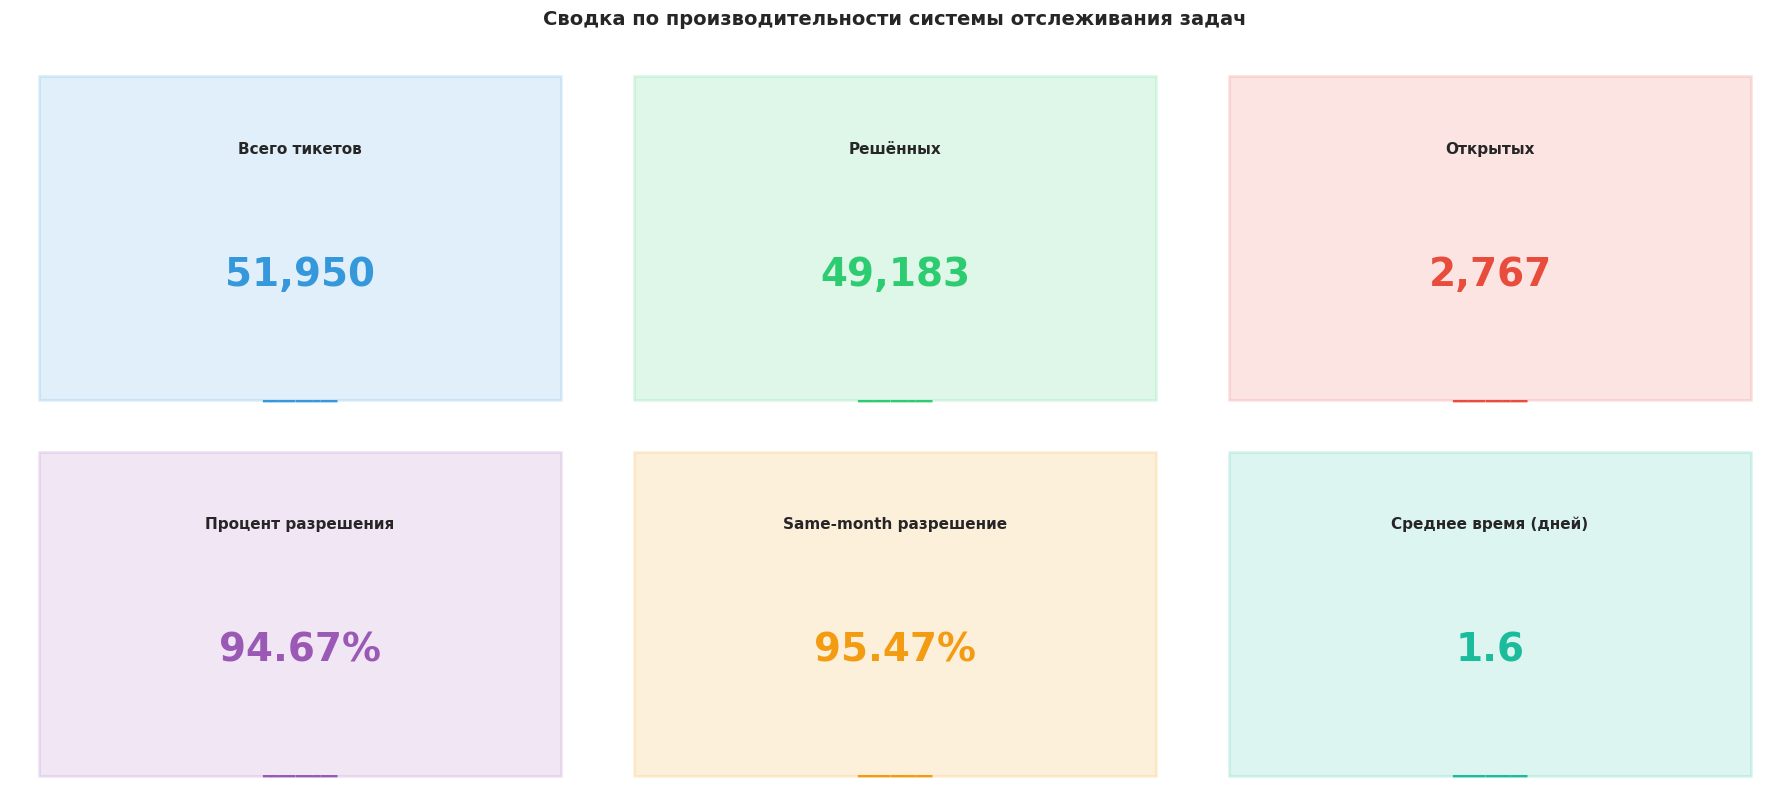

ИТОГОВАЯ СТАТИСТИКА:
Всего тикетов в системе:        51,950
Успешно решённых:               49,183 (94.67%)
Открытых (не решённых):         2,767 (5.33%)
Same-month разрешение:          95.47% (46,955 тикетов)
Среднее время разрешения:       1.6 дней
Медиана времени разрешения:     0.0 дней
Период данных:                  01.06.2023 → 30.06.2023
Уникальные категории:           4


In [47]:
print("\nБАЗОВЫЕ МЕТРИКИ СИСТЕМЫ")

total = len(issues_clean)
resolved = issues_clean['resolved_dt'].notna().sum()
unresolved = issues_clean['resolved_dt'].isna().sum()

# Same-month разрешение
same_month = issues_clean[
    issues_clean['resolved_dt'].notna() &
    (issues_clean['created_dt'].dt.to_period('M') == issues_clean['resolved_dt'].dt.to_period('M'))
].shape[0]
same_month_pct = (same_month / resolved * 100) if resolved > 0 else 0

# Среднее время разрешения (только для решённых тикетов с корректным временем)
resolved_issues = issues_clean[
    (issues_clean['resolved_dt'].notna()) &
    (issues_clean['days_to_resolve'] >= 0)
]
avg_days = resolved_issues['days_to_resolve'].mean()

fig, axes = plt.subplots(2, 3, figsize=(18, 8))
fig.suptitle('Сводка по производительности системы отслеживания задач',
             fontsize=14, fontweight='bold', y=1.00)

# Метрики для отображения
metrics = [
    ('Всего тикетов', f"{total:,}", '#3498db', 'бирюзовый'),
    ('Решённых', f"{resolved:,}", '#2ecc71', 'зелёный'),
    ('Открытых', f"{unresolved:,}", '#e74c3c', 'красный'),
    ('Процент разрешения', f"{100*resolved/total:.2f}%", '#9b59b6', 'фиолетовый'),
    ('Same-month разрешение', f"{same_month_pct:.2f}%", '#f39c12', 'оранжевый'),
    ('Среднее время (дней)', f"{avg_days:.1f}", '#1abc9c', 'бирюза')
]

# Рисуем метрики
for idx, (ax, (title, value, color, color_name)) in enumerate(zip(axes.flat, metrics)):
    # Фон
    ax.add_patch(plt.Rectangle((0.05, 0.05), 0.9, 0.9,
                               facecolor=color, alpha=0.15, edgecolor=color, linewidth=2))

    # Заголовок
    ax.text(0.5, 0.75, title, ha='center', va='center',
            fontsize=11, fontweight='bold', transform=ax.transAxes)

    # Значение
    ax.text(0.5, 0.4, value, ha='center', va='center',
            fontsize=28, fontweight='bold', color=color, transform=ax.transAxes)

    # Иконка/описание
    ax.text(0.5, 0.05, '━━━━━━━━━', ha='center', va='center',
            fontsize=10, color=color, fontweight='bold', transform=ax.transAxes)

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.axis('off')

plt.tight_layout()
plt.show()

# Выводим подробную информацию
print(f"ИТОГОВАЯ СТАТИСТИКА:")
print(f"Всего тикетов в системе:        {total:,}")
print(f"Успешно решённых:               {resolved:,} ({100*resolved/total:.2f}%)")
print(f"Открытых (не решённых):         {unresolved:,} ({100*unresolved/total:.2f}%)")
print(f"Same-month разрешение:          {same_month_pct:.2f}% ({same_month:,} тикетов)")
print(f"Среднее время разрешения:       {avg_days:.1f} дней")
print(f"Медиана времени разрешения:     {resolved_issues['days_to_resolve'].median():.1f} дней")
print(f"Период данных:                  {issues_clean['created_dt'].min().strftime('%d.%m.%Y')} → {issues_clean['created_dt'].max().strftime('%d.%m.%Y')}")
print(f"Уникальные категории:           {issues_clean['category'].nunique()}")



РАСПРЕДЕЛЕНИЯ ПО КАТЕГОРИЯМ


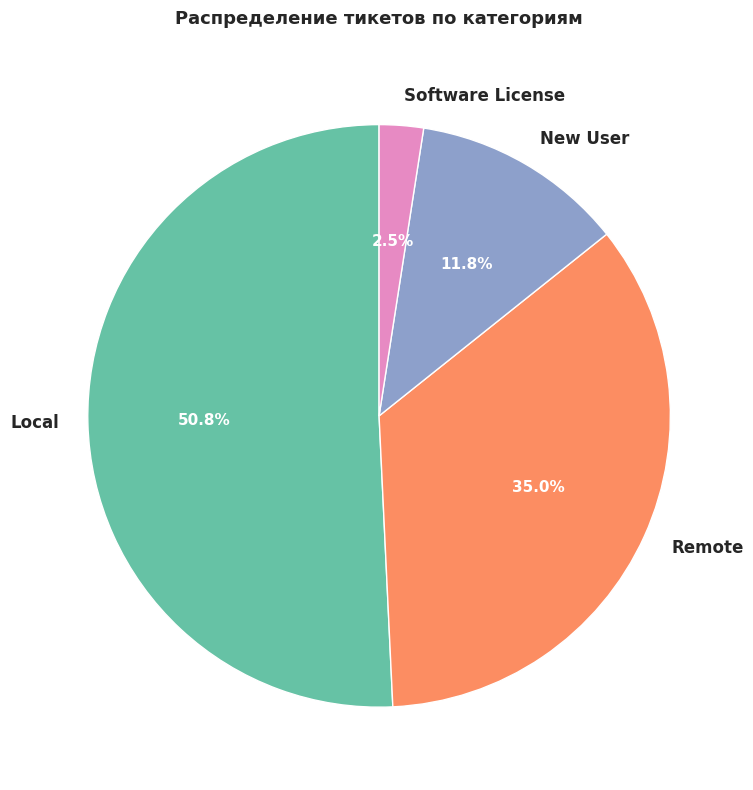

In [48]:
print("\nРАСПРЕДЕЛЕНИЯ ПО КАТЕГОРИЯМ")

# Подсчёт количества по категориям
category_counts = issues_clean.groupby('category').size()

# Объединяем в один DataFrame
category_stats = pd.DataFrame({
    'count': category_counts
}).sort_values('count', ascending=False)

fig, ax = plt.subplots(figsize=(10, 8))

colors = sns.color_palette("Set2", len(category_stats))
wedges, texts, autotexts = ax.pie(category_stats['count'],
                                    labels=category_stats.index,
                                    autopct='%1.1f%%',
                                    colors=colors,
                                    startangle=90,
                                    textprops={'fontsize': 12, 'fontweight': 'bold'})

ax.set_title('Распределение тикетов по категориям', fontsize=13, fontweight='bold', pad=20)

# Расширим текст процентов
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(11)

plt.tight_layout()
plt.show()


ОБЪЁМ ЗАДАЧ ПО КАТЕГОРИЯМ


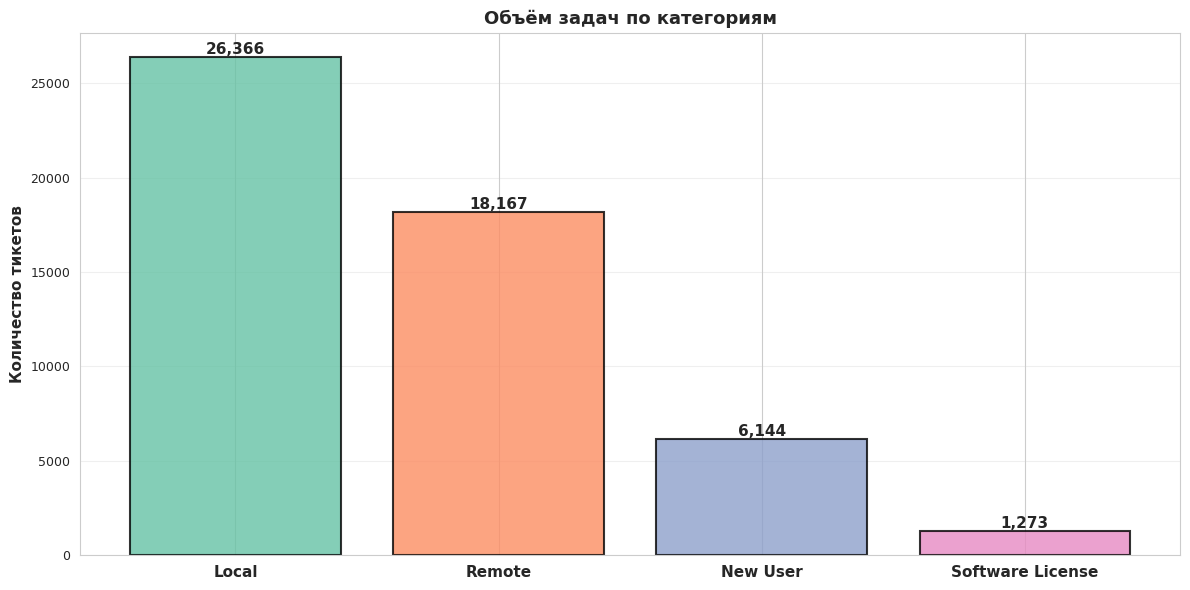

In [50]:
print("\nОБЪЁМ ЗАДАЧ ПО КАТЕГОРИЯМ")

# Подсчёт количества по категориям
category_counts = issues_clean.groupby('category').size()

category_stats = pd.DataFrame({
    'count': category_counts
}).sort_values('count', ascending=False)

fig, ax = plt.subplots(figsize=(12, 6))

colors = sns.color_palette("Set2", len(category_stats))
bars = ax.bar(range(len(category_stats)), category_stats['count'],
              color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

ax.set_xticks(range(len(category_stats)))
ax.set_xticklabels(category_stats.index, rotation=0, fontweight='bold', fontsize=11)
ax.set_ylabel('Количество тикетов', fontweight='bold', fontsize=11)
ax.set_title('Объём задач по категориям', fontsize=13, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Добавляем значения на столбцы
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()


ЭФФЕКТИВНОСТЬ РАЗРЕШЕНИЯ ПО КАТЕГОРИЯМ


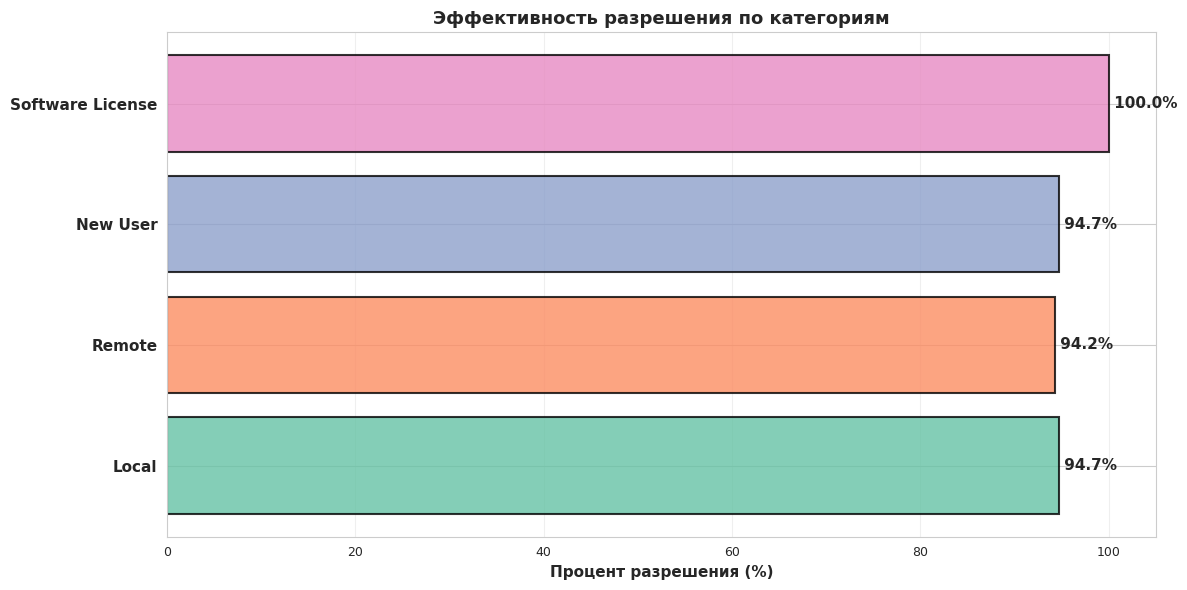

In [51]:
print("\nЭФФЕКТИВНОСТЬ РАЗРЕШЕНИЯ ПО КАТЕГОРИЯМ")

# Подсчёт по категориям
category_counts = issues_clean.groupby('category').size()

# Процент разрешения по категориям
resolution_rates = issues_clean.groupby('category')['resolved_dt'].apply(
    lambda x: (x.notna().sum() / len(x) * 100)
)

category_stats = pd.DataFrame({
    'count': category_counts,
    'resolution_rate': resolution_rates
}).sort_values('count', ascending=False)

fig, ax = plt.subplots(figsize=(12, 6))

colors = sns.color_palette("Set2", len(category_stats))
bars = ax.barh(range(len(category_stats)), category_stats['resolution_rate'],
               color=colors, alpha=0.8, edgecolor='black', linewidth=1.5)

ax.set_yticks(range(len(category_stats)))
ax.set_yticklabels(category_stats.index, fontweight='bold', fontsize=11)
ax.set_xlabel('Процент разрешения (%)', fontweight='bold', fontsize=11)
ax.set_title('Эффективность разрешения по категориям', fontsize=13, fontweight='bold')
ax.grid(axis='x', alpha=0.3)
ax.set_xlim(0, 105)

# Добавляем значения
for bar, rate in zip(bars, category_stats['resolution_rate']):
    width = bar.get_width()
    ax.text(width, bar.get_y() + bar.get_height()/2.,
            f' {rate:.1f}%',
            ha='left', va='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()


СВОДНАЯ ТАБЛИЦА ПО КАТЕГОРИЯМ


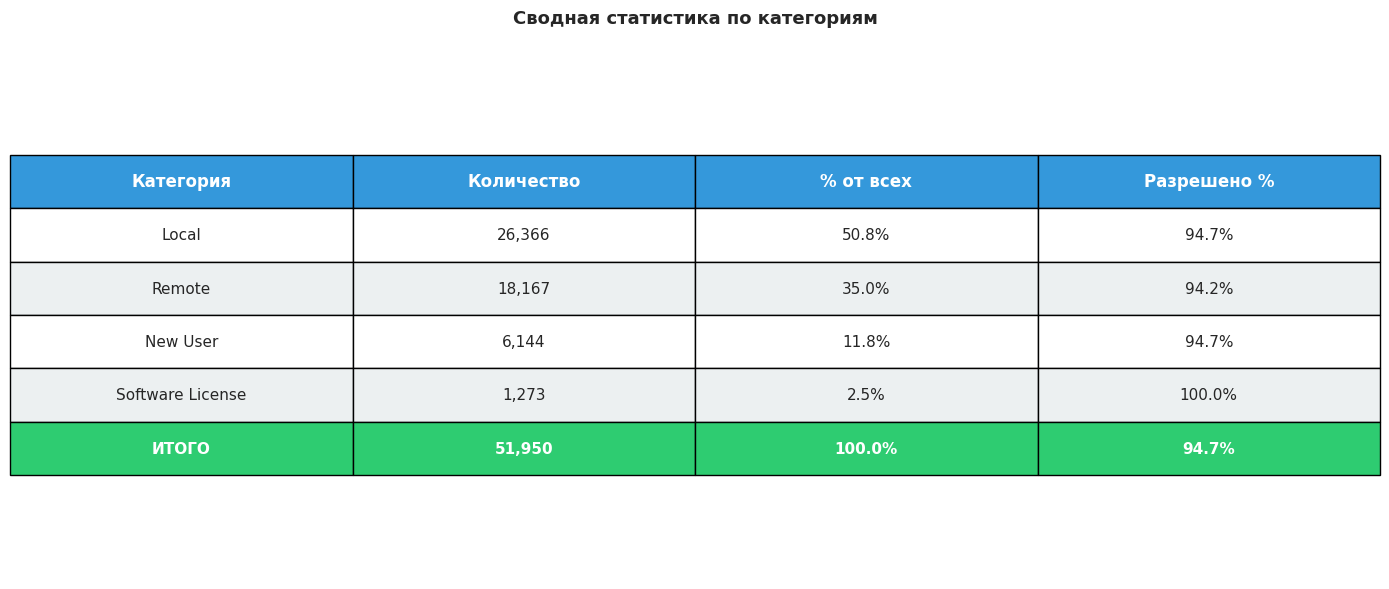

In [52]:
print("\nСВОДНАЯ ТАБЛИЦА ПО КАТЕГОРИЯМ")

# Подсчёт по категориям
category_counts = issues_clean.groupby('category').size()

# Процент разрешения по категориям
resolution_rates = issues_clean.groupby('category')['resolved_dt'].apply(
    lambda x: (x.notna().sum() / len(x) * 100)
)

category_stats = pd.DataFrame({
    'count': category_counts,
    'resolution_rate': resolution_rates
}).sort_values('count', ascending=False)

fig, ax = plt.subplots(figsize=(14, 6))
ax.axis('off')

# Создаём данные таблицы
table_data = []
table_data.append(['Категория', 'Количество', '% от всех', 'Разрешено %'])

for cat in category_stats.index:
    count = category_stats.loc[cat, 'count']
    pct = count / len(issues_clean) * 100
    resolution = category_stats.loc[cat, 'resolution_rate']
    table_data.append([cat, f'{int(count):,}', f'{pct:.1f}%', f'{resolution:.1f}%'])

# Всего
total_count = category_stats['count'].sum()
total_pct = total_count / len(issues_clean) * 100
total_resolution = (issues_clean['resolved_dt'].notna().sum() / len(issues_clean)) * 100
table_data.append(['ИТОГО', f'{int(total_count):,}', f'{total_pct:.1f}%', f'{total_resolution:.1f}%'])

# Создаём таблицу
table = ax.table(cellText=table_data, cellLoc='center', loc='center',
                colWidths=[0.25, 0.25, 0.25, 0.25])
table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.8)

# Форматируем заголовок
for i in range(len(table_data[0])):
    table[(0, i)].set_facecolor('#3498db')
    table[(0, i)].set_text_props(weight='bold', color='white', fontsize=12)

# Форматируем строки
for i in range(1, len(table_data) - 1):
    for j in range(len(table_data[0])):
        if i % 2 == 0:
            table[(i, j)].set_facecolor('#ecf0f1')
        else:
            table[(i, j)].set_facecolor('#ffffff')
        table[(i, j)].set_text_props(weight='normal', fontsize=11)

# Форматируем строку ИТОГО
for j in range(len(table_data[0])):
    table[(len(table_data) - 1, j)].set_facecolor('#2ecc71')
    table[(len(table_data) - 1, j)].set_text_props(weight='bold', color='white', fontsize=11)

ax.set_title('Сводная статистика по категориям', fontsize=13, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()


ТИПЫ РАЗРЕШЕНИЯ (РЕЗОЛЮЦИИ)
Найдено 5 типов разрешения
Всего решённых тикетов: 49,182



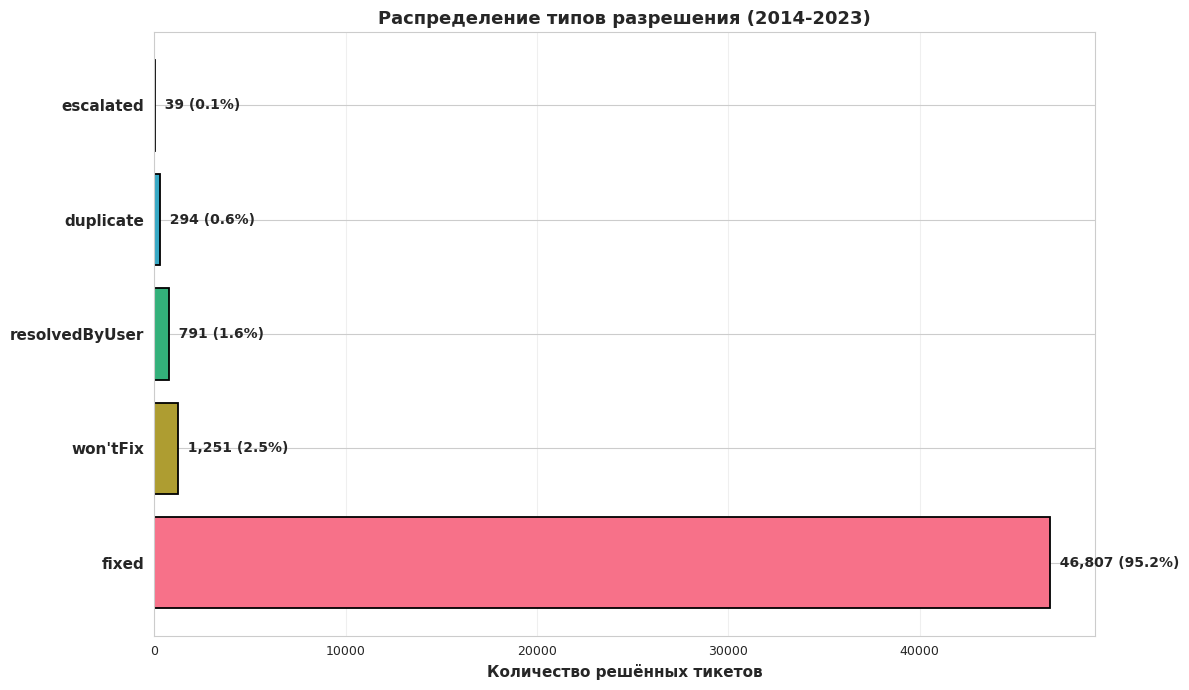

ТИПЫ РАЗРЕШЕНИЯ:
fixed: 46,807 (95.2%)
won'tFix: 1,251 (2.5%)
resolvedByUser: 791 (1.6%)
duplicate: 294 (0.6%)
escalated: 39 (0.1%)


In [54]:
print("\nТИПЫ РАЗРЕШЕНИЯ (РЕЗОЛЮЦИИ)")

# Фильтруем только решённые тикеты и убираем NaN из key_y (это колонка с типами разрешения)
resolved_df = issues_clean[
    (issues_clean['resolved_dt'].notna()) &
    (issues_clean['key_y'].notna())
].copy()

# Подсчитываем типы разрешения
resolution_stats = resolved_df['key_y'].value_counts()

print(f"Найдено {len(resolution_stats)} типов разрешения")
print(f"Всего решённых тикетов: {len(resolved_df):,}\n")

fig, ax = plt.subplots(figsize=(12, 7))

colors = sns.color_palette("husl", len(resolution_stats))
bars = ax.barh(range(len(resolution_stats)), resolution_stats.values,
               color=colors, edgecolor='black', linewidth=1.3)

ax.set_yticks(range(len(resolution_stats)))
ax.set_yticklabels(resolution_stats.index, fontweight='bold', fontsize=11)
ax.set_xlabel('Количество решённых тикетов', fontweight='bold', fontsize=11)
ax.set_title('Распределение типов разрешения (2014-2023)', fontsize=13, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

# Добавляем значения и проценты на столбцы
for i, (bar, count) in enumerate(zip(bars, resolution_stats.values)):
    pct = (count / len(resolved_df) * 100)
    ax.text(count, bar.get_y() + bar.get_height()/2.,
           f'  {int(count):,} ({pct:.1f}%)',
           va='center', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.show()

print(f"ТИПЫ РАЗРЕШЕНИЯ:")
for resolution_type, count in resolution_stats.items():
    pct = (count / len(resolved_df) * 100)
    print(f"{resolution_type}: {count:,} ({pct:.1f}%)")


SLA АНАЛИЗ (ПОРОГИ РАЗРЕШЕНИЯ)
Анализ SLA пороги
Всего решённых тикетов: 49,183
Среднее время разрешения: 1.63 дней



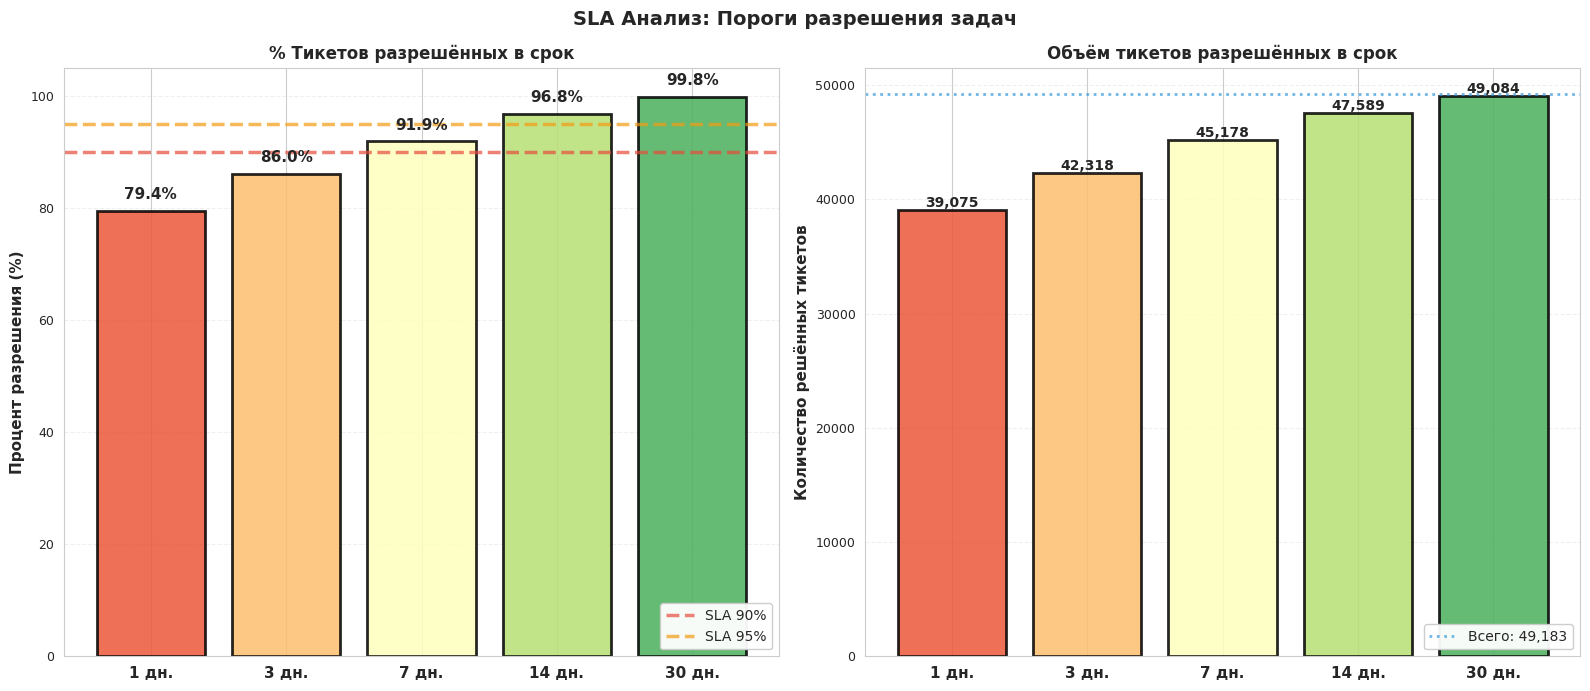

SLA СТАТИСТИКА (ДЕТАЛЬНЫЙ АНАЛИЗ):
   Порог |   Решено |  % разрешено | Не разрешено |  % не разрешено
      1д |   39,075 |        79.4% |       10,108 |           20.6%
      3д |   42,318 |        86.0% |        6,865 |           14.0%
      7д |   45,178 |        91.9% |        4,005 |            8.1%
     14д |   47,589 |        96.8% |        1,594 |            3.2%
     30д |   49,084 |        99.8% |           99 |            0.2%
ВЫВОДЫ:
  За 1 день разрешается: 79.4% задач
  За 3 дня разрешается: 86.0% задач
  За 30 дней разрешается: 99.8% задач
  Среднее время разрешения: 1.63 дней




In [55]:
print("\nSLA АНАЛИЗ (ПОРОГИ РАЗРЕШЕНИЯ)")

# Фильтруем только решённые тикеты с корректным временем разрешения
resolved_issues = issues_clean[
    (issues_clean['resolved_dt'].notna()) &
    (issues_clean['days_to_resolve'] >= 0)
].copy()

# Определяем пороги (в днях)
thresholds = [1, 3, 7, 14, 30]

# Подсчитываем процент разрешения за каждый порог
sla_stats = {}
for threshold in thresholds:
    count = (resolved_issues['days_to_resolve'] <= threshold).sum()
    pct = (count / len(resolved_issues) * 100)
    sla_stats[threshold] = {'count': count, 'pct': pct}

print(f"Анализ SLA пороги")
print(f"Всего решённых тикетов: {len(resolved_issues):,}")
print(f"Среднее время разрешения: {resolved_issues['days_to_resolve'].mean():.2f} дней\n")

# ВИЗУАЛИЗАЦИЯ - 2 графика
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle('SLA Анализ: Пороги разрешения задач', fontsize=14, fontweight='bold')

thresholds_labels = [f'{t} дн.' for t in thresholds]
percentages = [sla_stats[t]['pct'] for t in thresholds]
counts = [sla_stats[t]['count'] for t in thresholds]

# ========== ГРАФИК 1: Столбцы с процентами ==========
colors = sns.color_palette("RdYlGn", len(thresholds))
bars1 = ax1.bar(range(len(thresholds)), percentages,
               color=colors, alpha=0.85, edgecolor='black', linewidth=2)

ax1.set_xticks(range(len(thresholds)))
ax1.set_xticklabels(thresholds_labels, fontweight='bold', fontsize=11)
ax1.set_ylabel('Процент разрешения (%)', fontweight='bold', fontsize=11)
ax1.set_title('% Тикетов разрешённых в срок', fontsize=12, fontweight='bold')
ax1.set_ylim(0, 105)
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# Добавляем значения на столбцы
for bar, pct in zip(bars1, percentages):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 1.5,
            f'{pct:.1f}%',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# Целевые линии
ax1.axhline(y=90, color='#e74c3c', linestyle='--', linewidth=2.5, alpha=0.7, label='SLA 90%')
ax1.axhline(y=95, color='#f39c12', linestyle='--', linewidth=2.5, alpha=0.7, label='SLA 95%')
ax1.legend(loc='lower right', fontsize=10, framealpha=0.95)

# ========== ГРАФИК 2: Столбцы с количеством ==========
bars2 = ax2.bar(range(len(thresholds)), counts,
               color=colors, alpha=0.85, edgecolor='black', linewidth=2)

ax2.set_xticks(range(len(thresholds)))
ax2.set_xticklabels(thresholds_labels, fontweight='bold', fontsize=11)
ax2.set_ylabel('Количество решённых тикетов', fontweight='bold', fontsize=11)
ax2.set_title('Объём тикетов разрешённых в срок', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# Добавляем значения на столбцы
for bar, count in zip(bars2, counts):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(count):,}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# Линия среднего значения
avg_line = len(resolved_issues)
ax2.axhline(y=avg_line, color='#3498db', linestyle=':', linewidth=2, alpha=0.7, label=f'Всего: {avg_line:,}')
ax2.legend(loc='lower right', fontsize=10, framealpha=0.95)

plt.tight_layout()
plt.show()

print(f"SLA СТАТИСТИКА (ДЕТАЛЬНЫЙ АНАЛИЗ):")
print(f"{'Порог':>8} | {'Решено':>8} | {'% разрешено':>12} | {'Не разрешено':>12} | {'% не разрешено':>15}")

total = len(resolved_issues)
for threshold in thresholds:
    resolved_count = sla_stats[threshold]['count']
    resolved_pct = sla_stats[threshold]['pct']
    unresolved_count = total - resolved_count
    unresolved_pct = 100 - resolved_pct
    print(f"{threshold:>7}д | {resolved_count:>8,} | {resolved_pct:>11.1f}% | {unresolved_count:>12,} | {unresolved_pct:>14.1f}%")

print(f"ВЫВОДЫ:")
print(f"  За {thresholds[0]} день разрешается: {sla_stats[1]['pct']:.1f}% задач")
print(f"  За {thresholds[1]} дня разрешается: {sla_stats[3]['pct']:.1f}% задач")
print(f"  За {thresholds[4]} дней разрешается: {sla_stats[30]['pct']:.1f}% задач")
print(f"  Среднее время разрешения: {resolved_issues['days_to_resolve'].mean():.2f} дней")
print(f"\n")


КВАНТИЛИ ВРЕМЕНИ РАЗРЕШЕНИЯ
Расчёт квантилей времени разрешения



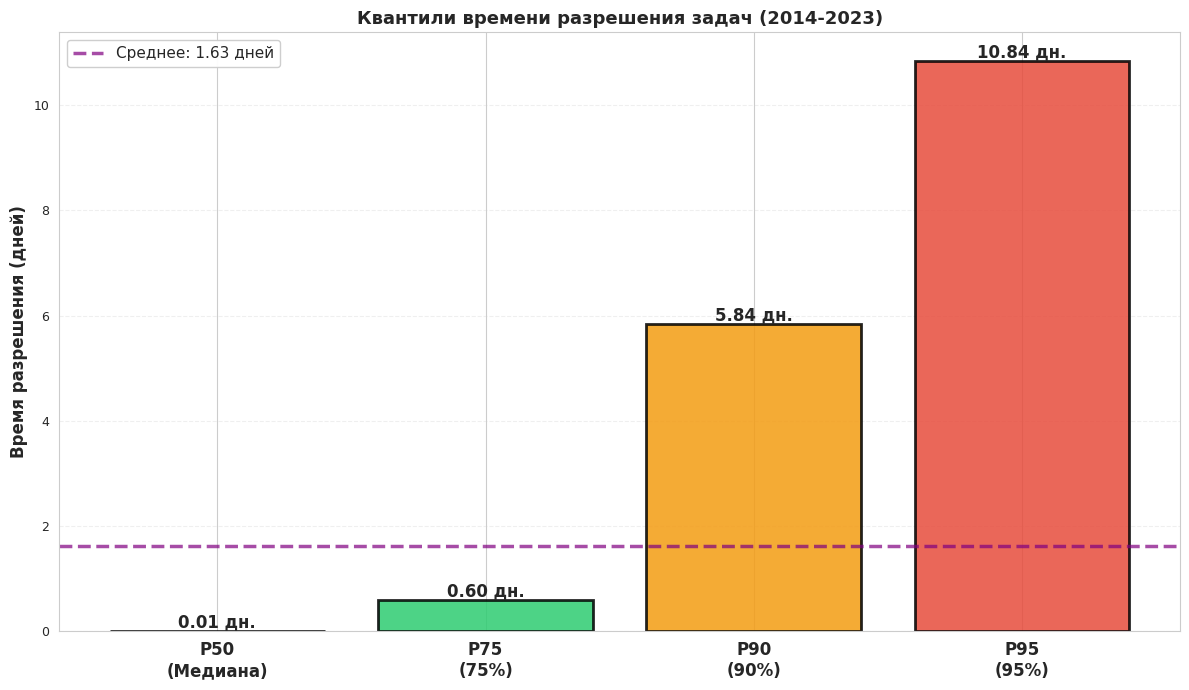

СТАТИСТИКА КВАНТИЛЕЙ:
  P50 (Медиана):  0.01 дней - половина задач решается за это время
  P75 (75-й %):   0.60 дней - 75% задач решается за это время
  P90 (90-й %):   5.84 дней - 90% задач решается за это время
  P95 (95-й %):   10.84 дней - 95% задач решается за это время

  Среднее значение: 1.63 дней
  Минимум: 0.00 дней
  Максимум: 36.02 дней


In [56]:
print("\nКВАНТИЛИ ВРЕМЕНИ РАЗРЕШЕНИЯ")

# Фильтруем только решённые тикеты с корректным временем
resolved_issues = issues_clean[
    (issues_clean['resolved_dt'].notna()) &
    (issues_clean['days_to_resolve'] >= 0)
].copy()

# Вычисляем квантили
quantiles = [0.5, 0.75, 0.90, 0.95]
quantile_values = [resolved_issues['days_to_resolve'].quantile(q) for q in quantiles]
quantile_labels = ['P50\n(Медиана)', 'P75\n(75%)', 'P90\n(90%)', 'P95\n(95%)']

print(f"Расчёт квантилей времени разрешения\n")

fig, ax = plt.subplots(figsize=(12, 7))

colors = ['#3498db', '#2ecc71', '#f39c12', '#e74c3c']
bars = ax.bar(range(len(quantile_labels)), quantile_values,
              color=colors, alpha=0.85, edgecolor='black', linewidth=2)

ax.set_xticks(range(len(quantile_labels)))
ax.set_xticklabels(quantile_labels, fontweight='bold', fontsize=12)
ax.set_ylabel('Время разрешения (дней)', fontweight='bold', fontsize=12)
ax.set_title('Квантили времени разрешения задач (2014-2023)', fontsize=13, fontweight='bold')
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Добавляем значения на столбцы
for bar, value in zip(bars, quantile_values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{value:.2f} дн.',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

# Добавляем среднее значение линией
mean_value = resolved_issues['days_to_resolve'].mean()
ax.axhline(y=mean_value, color='purple', linestyle='--', linewidth=2.5,
           alpha=0.7, label=f'Среднее: {mean_value:.2f} дней')

ax.legend(loc='upper left', fontsize=11, framealpha=0.95)

plt.tight_layout()
plt.show()

print(f"СТАТИСТИКА КВАНТИЛЕЙ:")
print(f"  P50 (Медиана):  {quantile_values[0]:.2f} дней - половина задач решается за это время")
print(f"  P75 (75-й %):   {quantile_values[1]:.2f} дней - 75% задач решается за это время")
print(f"  P90 (90-й %):   {quantile_values[2]:.2f} дней - 90% задач решается за это время")
print(f"  P95 (95-й %):   {quantile_values[3]:.2f} дней - 95% задач решается за это время")
print(f"\n  Среднее значение: {mean_value:.2f} дней")
print(f"  Минимум: {resolved_issues['days_to_resolve'].min():.2f} дней")
print(f"  Максимум: {resolved_issues['days_to_resolve'].max():.2f} дней")


SAME-MONTH РАЗРЕШЕНИЕ (В ОДИН МЕСЯЦ)
Анализ Same-month разрешения
Всего решённых тикетов: 49,183



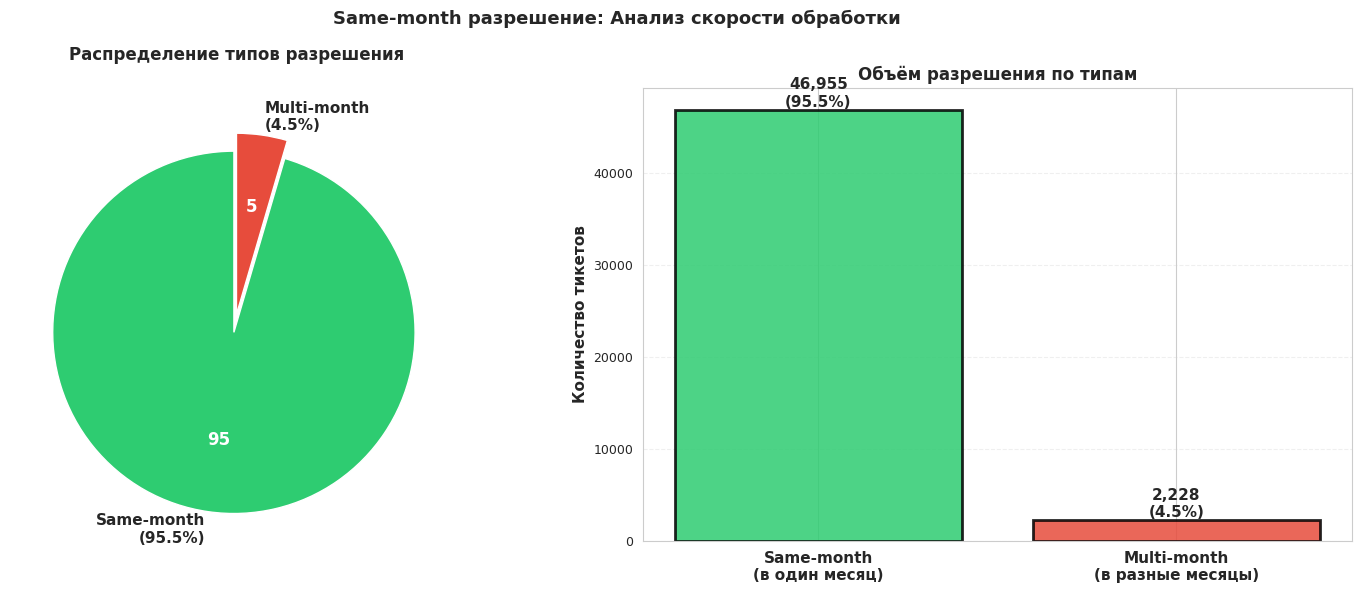

СТАТИСТИКА SAME-MONTH РАЗРЕШЕНИЯ:
  Same-month (в один месяц):      46,955 (95.47%)
  Multi-month (в разные месяцы):   2,228 ( 4.53%)
  ─────────────────────────────────────────────────────
  ИТОГО решённых:                 49,183 (100.00%)
ВЫВОД:
  Отличное качество обработки! 95.5% задач решаются в один месяц




In [58]:
print("\nSAME-MONTH РАЗРЕШЕНИЕ (В ОДИН МЕСЯЦ)")

# Фильтруем только решённые тикеты
resolved_issues = issues_clean[issues_clean['resolved_dt'].notna()].copy()

# Same-month разрешение: когда создание и разрешение в одном месяце
same_month_mask = (resolved_issues['created_dt'].dt.to_period('M') ==
                   resolved_issues['resolved_dt'].dt.to_period('M'))
same_month_count = same_month_mask.sum()
same_month_pct = (same_month_count / len(resolved_issues)) * 100

# Different month разрешение
diff_month_count = len(resolved_issues) - same_month_count
diff_month_pct = 100 - same_month_pct

print(f"Анализ Same-month разрешения")
print(f"Всего решённых тикетов: {len(resolved_issues):,}\n")

# ВИЗУАЛИЗАЦИЯ - 2 графика
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Same-month разрешение: Анализ скорости обработки',
             fontsize=13, fontweight='bold')

# ========== ГРАФИК 1: Пирог ==========
sizes = [same_month_count, diff_month_count]
labels = [f'Same-month\n({same_month_pct:.1f}%)',
          f'Multi-month\n({diff_month_pct:.1f}%)']
colors_pie = ['#2ecc71', '#e74c3c']
explode = (0.1, 0)

wedges, texts, autotexts = ax1.pie(sizes, labels=labels, autopct='%1.0f',
                                     colors=colors_pie, explode=explode,
                                     startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(12)
    autotext.set_fontweight('bold')

ax1.set_title('Распределение типов разрешения', fontsize=12, fontweight='bold', pad=20)

# ========== ГРАФИК 2: Столбцы ==========
categories = ['Same-month\n(в один месяц)', 'Multi-month\n(в разные месяцы)']
counts = [same_month_count, diff_month_count]
percentages = [same_month_pct, diff_month_pct]

bars = ax2.bar(range(len(categories)), counts,
               color=colors_pie, alpha=0.85, edgecolor='black', linewidth=2)

ax2.set_xticks(range(len(categories)))
ax2.set_xticklabels(categories, fontweight='bold', fontsize=11)
ax2.set_ylabel('Количество тикетов', fontweight='bold', fontsize=11)
ax2.set_title('Объём разрешения по типам', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# Добавляем значения на столбцы
for bar, count, pct in zip(bars, counts, percentages):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(count):,}\n({pct:.1f}%)',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"СТАТИСТИКА SAME-MONTH РАЗРЕШЕНИЯ:")
print(f"  Same-month (в один месяц):     {same_month_count:>7,} ({same_month_pct:>5.2f}%)")
print(f"  Multi-month (в разные месяцы): {diff_month_count:>7,} ({diff_month_pct:>5.2f}%)")
print(f"  ─────────────────────────────────────────────────────")
print(f"  ИТОГО решённых:                {len(resolved_issues):>7,} (100.00%)")

print(f"ВЫВОД:")
if same_month_pct >= 95:
    print(f"  Отличное качество обработки! {same_month_pct:.1f}% задач решаются в один месяц")
elif same_month_pct >= 85:
    print(f"  Хорошее качество обработки. {same_month_pct:.1f}% задач решаются в один месяц")
else:
    print(f"  Требует улучшения. Только {same_month_pct:.1f}% задач решаются в один месяц")
print(f"\n")


ДОЛГИЕ ЗАДАЧИ (LONG-RUNNING ISSUES)
Анализ долгих задач
Всего решённых тикетов: 49,183



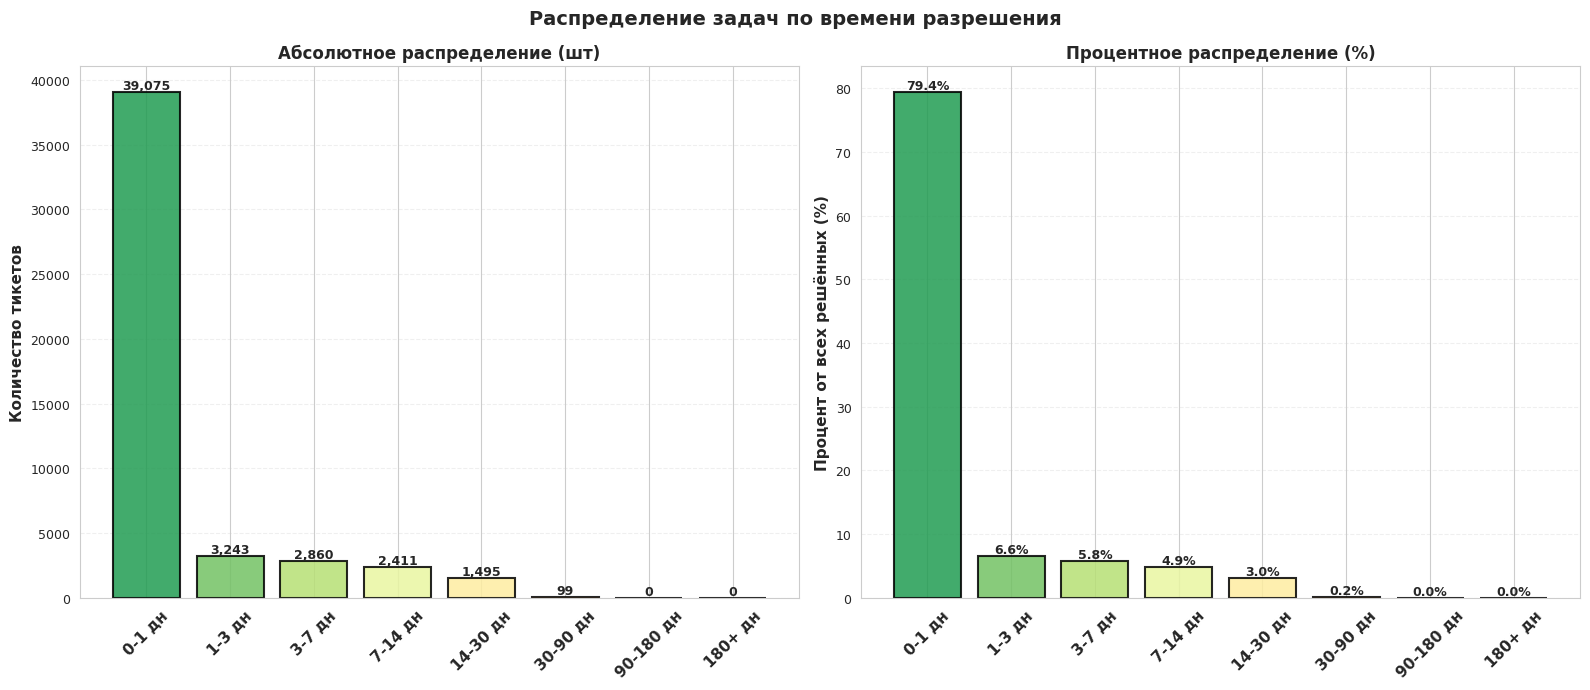

СТАТИСТИКА РАСПРЕДЕЛЕНИЯ ПО ВРЕМЕНИ РАЗРЕШЕНИЯ:
    Интервал |   Количество |    Процент |  Копулятив %
      0-1 дн |       39,075 |     79.45% |       79.45%
      1-3 дн |        3,243 |      6.59% |       86.04%
      3-7 дн |        2,860 |      5.82% |       91.86%
     7-14 дн |        2,411 |      4.90% |       96.76%
    14-30 дн |        1,495 |      3.04% |       99.80%
    30-90 дн |           99 |      0.20% |      100.00%
   90-180 дн |            0 |      0.00% |      100.00%
     180+ дн |            0 |      0.00% |      100.00%
ДОЛГИЕ ЗАДАЧИ (> 30 ДНЕЙ):
Долгие (> 30 дн):       99 ( 0.20%)

ДОЛГИЕ ЗАДАЧИ ПО КАТЕГОРИЯМ (> 30 дней):

  Local               :     53 ( 0.21%)
  New User            :     11 ( 0.19%)
  Remote              :     35 ( 0.20%)
  Software License    :      0 ( 0.00%)


In [61]:
print("\nДОЛГИЕ ЗАДАЧИ (LONG-RUNNING ISSUES)")

# Фильтруем только решённые тикеты с корректным временем
resolved_issues = issues_clean[
    (issues_clean['resolved_dt'].notna()) &
    (issues_clean['days_to_resolve'] >= 0)
].copy()

total = len(resolved_issues)

print(f"Анализ долгих задач")
print(f"Всего решённых тикетов: {total:,}\n")

# Создаём бакеты (интервалы)
bins = [0, 1, 3, 7, 14, 30, 90, 180, float('inf')]
labels = ['0-1 дн', '1-3 дн', '3-7 дн', '7-14 дн', '14-30 дн', '30-90 дн', '90-180 дн', '180+ дн']
resolved_issues['time_bucket'] = pd.cut(resolved_issues['days_to_resolve'], bins=bins, labels=labels)

bucket_counts = resolved_issues['time_bucket'].value_counts().sort_index()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle('Распределение задач по времени разрешения', fontsize=14, fontweight='bold')

# ========== ГРАФИК 1: Столбцы абсолютные ==========
colors_gradient = sns.color_palette("RdYlGn_r", len(bucket_counts))
bars1 = ax1.bar(range(len(bucket_counts)), bucket_counts.values,
                color=colors_gradient, alpha=0.85, edgecolor='black', linewidth=1.5)

ax1.set_xticks(range(len(bucket_counts)))
ax1.set_xticklabels(bucket_counts.index, fontweight='bold', fontsize=11, rotation=45)
ax1.set_ylabel('Количество тикетов', fontweight='bold', fontsize=11)
ax1.set_title('Абсолютное распределение (шт)', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3, linestyle='--')

for bar, count in zip(bars1, bucket_counts.values):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(count):,}',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

# ========== ГРАФИК 2: Столбцы процентные ==========
percentages = (bucket_counts.values / total) * 100
bars2 = ax2.bar(range(len(bucket_counts)), percentages,
                color=colors_gradient, alpha=0.85, edgecolor='black', linewidth=1.5)

ax2.set_xticks(range(len(bucket_counts)))
ax2.set_xticklabels(bucket_counts.index, fontweight='bold', fontsize=11, rotation=45)
ax2.set_ylabel('Процент от всех решённых (%)', fontweight='bold', fontsize=11)
ax2.set_title('Процентное распределение (%)', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3, linestyle='--')

for bar, pct in zip(bars2, percentages):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{pct:.1f}%',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"СТАТИСТИКА РАСПРЕДЕЛЕНИЯ ПО ВРЕМЕНИ РАЗРЕШЕНИЯ:")
print(f"{'Интервал':>12} | {'Количество':>12} | {'Процент':>10} | {'Копулятив %':>12}")

cumulative = 0
for interval, count in bucket_counts.items():
    pct = (count / total) * 100
    cumulative += pct
    print(f"{str(interval):>12} | {count:>12,} | {pct:>9.2f}% | {cumulative:>11.2f}%")


# Долгие задачи (> 30 дней)
long_30_count = (resolved_issues['days_to_resolve'] > 30).sum()
long_30_pct = (long_30_count / total) * 100

print(f"ДОЛГИЕ ЗАДАЧИ (> 30 ДНЕЙ):")
print(f"Долгие (> 30 дн):   {long_30_count:>6,} ({long_30_pct:>5.2f}%)")

# По категориям
print(f"\nДОЛГИЕ ЗАДАЧИ ПО КАТЕГОРИЯМ (> 30 дней):\n")
for category in sorted(resolved_issues['category'].unique()):
    cat_issues = resolved_issues[resolved_issues['category'] == category]
    long_30_cat = (cat_issues['days_to_resolve'] > 30).sum()
    long_30_cat_pct = (long_30_cat / len(cat_issues)) * 100 if len(cat_issues) > 0 else 0
    print(f"  {category:20s}: {long_30_cat:>6,} ({long_30_cat_pct:>5.2f}%)")


BACKLOG AGING (ВОЗРАСТ ОТКРЫТЫХ ЗАДАЧ)
ℹДата расчёта (последняя дата в данных): 30.06.2023

Анализ возраста открытых задач
Всего открытых тикетов: 2,767



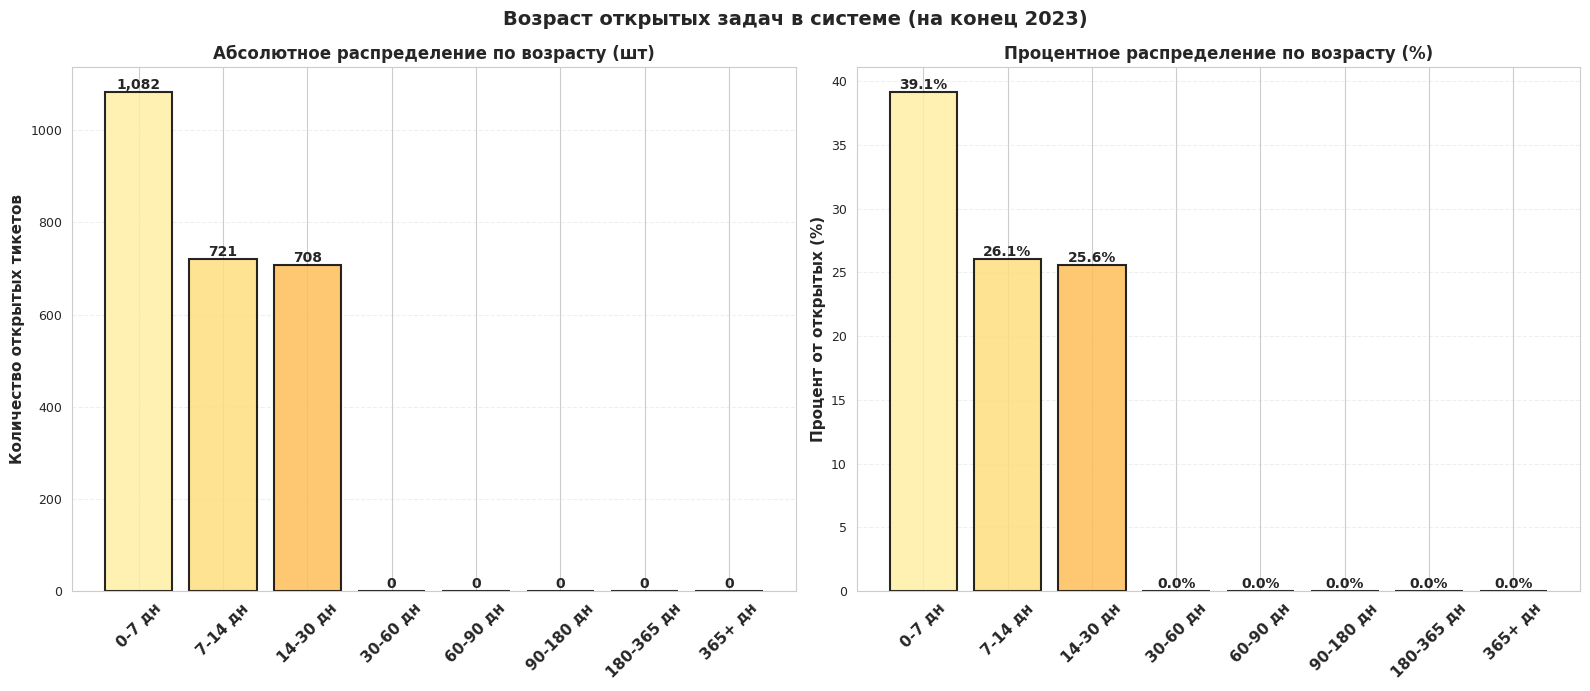

СТАТИСТИКА BACKLOG AGING:
     Возраст |     Кол-во |    % от всех |  Кумулятив %
      0-7 дн |      1,082 |       39.10% |       39.10%
     7-14 дн |        721 |       26.06% |       65.16%
    14-30 дн |        708 |       25.59% |       90.75%
    30-60 дн |          0 |        0.00% |       90.75%
    60-90 дн |          0 |        0.00% |       90.75%
   90-180 дн |          0 |        0.00% |       90.75%
  180-365 дн |          0 |        0.00% |       90.75%
     365+ дн |          0 |        0.00% |       90.75%
КРИТИЧЕСКИЕ МЕТРИКИ:
  Открыто свыше 90 дней:       0 ( 0.00%) - ТРЕБУЕТ ВНИМАНИЯ!
  Среднее время в статусе: 9.2 дней
  Самая старая задача:     29 дней (0.1 лет)

ОТКРЫТЫЕ ЗАДАЧИ ПО КАТЕГОРИЯМ:

  Local               : 1,399 шт (средний возраст    8.9 дн, старше 90 дн:    0)
  New User            :   323 шт (средний возраст   10.5 дн, старше 90 дн:    0)
  Remote              : 1,045 шт (средний возраст    9.3 дн, старше 90 дн:    0)


In [62]:
print("\nBACKLOG AGING (ВОЗРАСТ ОТКРЫТЫХ ЗАДАЧ)")

# Фильтруем только ОТКРЫТЫЕ (не решённые) тикеты
open_issues = issues_clean[issues_clean['resolved_dt'].isna()].copy()

# Используем ПОСЛЕДНЮЮ ДАТУ из данных как "сегодня"
reference_date = issues_clean['created_dt'].max()
print(f"ℹДата расчёта (последняя дата в данных): {reference_date.strftime('%d.%m.%Y')}\n")

# Вычисляем возраст в днях (от создания до последней даты в данных)
open_issues['age_days'] = (reference_date - open_issues['created_dt']).dt.days

total_open = len(open_issues)

print(f"Анализ возраста открытых задач")
print(f"Всего открытых тикетов: {total_open:,}\n")

# Создаём бакеты по возрасту
bins_age = [0, 7, 14, 30, 60, 90, 180, 365, float('inf')]
labels_age = ['0-7 дн', '7-14 дн', '14-30 дн', '30-60 дн', '60-90 дн', '90-180 дн', '180-365 дн', '365+ дн']
open_issues['age_bucket'] = pd.cut(open_issues['age_days'], bins=bins_age, labels=labels_age)

bucket_counts_age = open_issues['age_bucket'].value_counts().sort_index()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle('Возраст открытых задач в системе (на конец 2023)', fontsize=14, fontweight='bold')

# ========== ГРАФИК 1: Столбцы абсолютные ==========
colors_age = sns.color_palette("YlOrRd", len(bucket_counts_age))
bars1 = ax1.bar(range(len(bucket_counts_age)), bucket_counts_age.values,
                color=colors_age, alpha=0.85, edgecolor='black', linewidth=1.5)

ax1.set_xticks(range(len(bucket_counts_age)))
ax1.set_xticklabels(bucket_counts_age.index, fontweight='bold', fontsize=11, rotation=45)
ax1.set_ylabel('Количество открытых тикетов', fontweight='bold', fontsize=11)
ax1.set_title('Абсолютное распределение по возрасту (шт)', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3, linestyle='--')

for bar, count in zip(bars1, bucket_counts_age.values):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(count):,}',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# ========== ГРАФИК 2: Столбцы процентные ==========
percentages_age = (bucket_counts_age.values / total_open) * 100
bars2 = ax2.bar(range(len(bucket_counts_age)), percentages_age,
                color=colors_age, alpha=0.85, edgecolor='black', linewidth=1.5)

ax2.set_xticks(range(len(bucket_counts_age)))
ax2.set_xticklabels(bucket_counts_age.index, fontweight='bold', fontsize=11, rotation=45)
ax2.set_ylabel('Процент от открытых (%)', fontweight='bold', fontsize=11)
ax2.set_title('Процентное распределение по возрасту (%)', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3, linestyle='--')

for bar, pct in zip(bars2, percentages_age):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{pct:.1f}%',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"СТАТИСТИКА BACKLOG AGING:")
print(f"{'Возраст':>12} | {'Кол-во':>10} | {'% от всех':>12} | {'Кумулятив %':>12}")

cumulative_age = 0
for interval, count in bucket_counts_age.items():
    pct = (count / total_open) * 100
    cumulative_age += pct
    print(f"{str(interval):>12} | {count:>10,} | {pct:>11.2f}% | {cumulative_age:>11.2f}%")

# Опасные (> 90 дней)
dangerous = (open_issues['age_days'] > 90).sum()
dangerous_pct = (dangerous / total_open) * 100 if total_open > 0 else 0

print(f"КРИТИЧЕСКИЕ МЕТРИКИ:")
print(f"  Открыто свыше 90 дней:  {dangerous:>6,} ({dangerous_pct:>5.2f}%) - ТРЕБУЕТ ВНИМАНИЯ!")
print(f"  Среднее время в статусе: {open_issues['age_days'].mean():.1f} дней")
print(f"  Самая старая задача:     {open_issues['age_days'].max():.0f} дней ({open_issues['age_days'].max()/365:.1f} лет)")

# По категориям
print(f"\nОТКРЫТЫЕ ЗАДАЧИ ПО КАТЕГОРИЯМ:\n")
for category in sorted(open_issues['category'].unique()):
    cat_open = open_issues[open_issues['category'] == category]
    count = len(cat_open)
    avg_age = cat_open['age_days'].mean()
    old_90 = (cat_open['age_days'] > 90).sum()
    print(f"  {category:20s}: {count:>5,} шт (средний возраст {avg_age:>6.1f} дн, старше 90 дн: {old_90:>4,})")


ПАТТЕРНЫ ПО ДНЯМ НЕДЕЛИ
Анализ паттернов по дням недели
Всего задач: 51,950



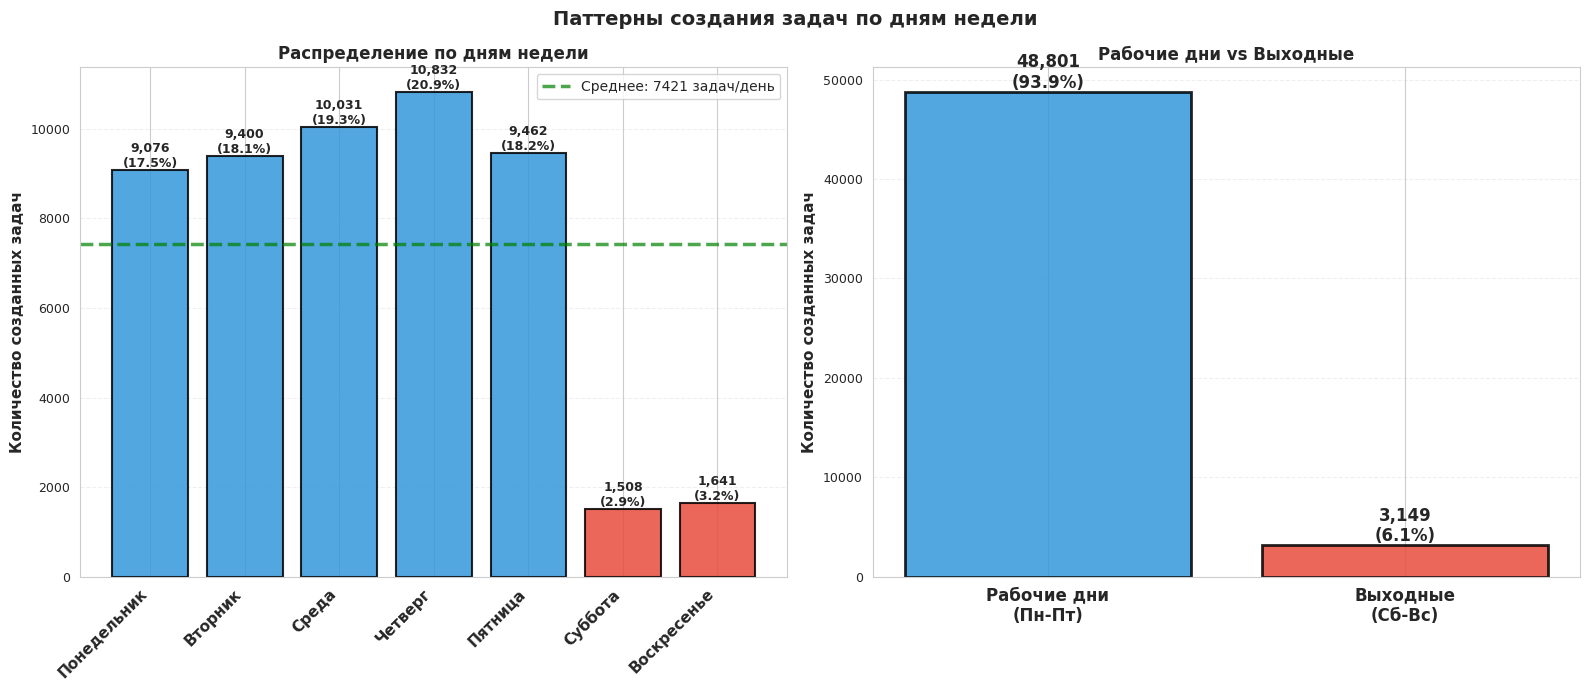

СТАТИСТИКА ПО ДНЯМ НЕДЕЛИ:
           День |     Кол-во |    % от всех |    На день
    Понедельник |      9,076 |       17.47% |       908
        Вторник |      9,400 |       18.09% |       940
          Среда |     10,031 |       19.31% |      1003
        Четверг |     10,832 |       20.85% |      1083
        Пятница |      9,462 |       18.21% |       946
        Суббота |      1,508 |        2.90% |       151
    Воскресенье |      1,641 |        3.16% |       164
АНАЛИЗ ПАТТЕРНОВ:
  Рабочие дни (Пн-Пт):    48,801 (93.94%)
  Выходные (Сб-Вс):        3,149 (6.06%)
  Соотношение раб/выходные: 15.50x

  Самый активный день: Четверг (10,832 задач)
  Самый тихий день: Суббота (1,508 задач)
  Стандартное отклонение: 4034 (ниже = более равномерное)
  Вывод: Задачи создаются в основном в РАБОЧИЕ ДНИ


In [63]:
print("\nПАТТЕРНЫ ПО ДНЯМ НЕДЕЛИ")

# Извлекаем день недели
issues_clean['day_of_week'] = issues_clean['created_dt'].dt.day_name()
issues_clean['day_of_week_num'] = issues_clean['created_dt'].dt.dayofweek

# Определяем порядок дней (с понедельника по воскресенье)
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_labels_ru = ['Понедельник', 'Вторник', 'Среда', 'Четверг', 'Пятница', 'Суббота', 'Воскресенье']

# Подсчитываем по дням недели
day_counts = issues_clean['day_of_week'].value_counts().reindex(day_order)
day_counts_dict = dict(zip(day_labels_ru, day_counts.values))

# По типам: рабочие vs выходные
weekday_count = issues_clean[issues_clean['day_of_week_num'] < 5].shape[0]
weekend_count = issues_clean[issues_clean['day_of_week_num'] >= 5].shape[0]

total = len(issues_clean)

print(f"Анализ паттернов по дням недели")
print(f"Всего задач: {total:,}\n")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle('Паттерны создания задач по дням недели', fontsize=14, fontweight='bold')

# ========== ГРАФИК 1: Столбцы по дням ==========
colors_days = ['#3498db'] * 5 + ['#e74c3c'] * 2  # Синий для рабочих, красный для выходных
bars1 = ax1.bar(range(len(day_labels_ru)), day_counts.values,
                color=colors_days, alpha=0.85, edgecolor='black', linewidth=1.5)

ax1.set_xticks(range(len(day_labels_ru)))
ax1.set_xticklabels(day_labels_ru, fontweight='bold', fontsize=11, rotation=45, ha='right')
ax1.set_ylabel('Количество созданных задач', fontweight='bold', fontsize=11)
ax1.set_title('Распределение по дням недели', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3, linestyle='--')

# Добавляем значения и проценты
for bar, count in zip(bars1, day_counts.values):
    height = bar.get_height()
    pct = (count / total) * 100
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(count):,}\n({pct:.1f}%)',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

# Линия среднего значения
mean_per_day = total / 7
ax1.axhline(y=mean_per_day, color='green', linestyle='--', linewidth=2.5,
           alpha=0.7, label=f'Среднее: {mean_per_day:.0f} задач/день')
ax1.legend(loc='upper right', fontsize=10)

# ========== ГРАФИК 2: Рабочие vs выходные ==========
categories_wd = ['Рабочие дни\n(Пн-Пт)', 'Выходные\n(Сб-Вс)']
counts_wd = [weekday_count, weekend_count]
percentages_wd = [
    (weekday_count / total) * 100,
    (weekend_count / total) * 100
]
colors_wd = ['#3498db', '#e74c3c']

bars2 = ax2.bar(range(len(categories_wd)), counts_wd,
               color=colors_wd, alpha=0.85, edgecolor='black', linewidth=2)

ax2.set_xticks(range(len(categories_wd)))
ax2.set_xticklabels(categories_wd, fontweight='bold', fontsize=12)
ax2.set_ylabel('Количество созданных задач', fontweight='bold', fontsize=11)
ax2.set_title('Рабочие дни vs Выходные', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3, linestyle='--')

# Добавляем значения
for bar, count, pct in zip(bars2, counts_wd, percentages_wd):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(count):,}\n({pct:.1f}%)',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"СТАТИСТИКА ПО ДНЯМ НЕДЕЛИ:")
print(f"{'День':>15} | {'Кол-во':>10} | {'% от всех':>12} | {'На день':>10}")

for idx, day_label in enumerate(day_labels_ru):
    day_order_name = day_order[idx]
    count = day_counts[day_order_name]
    pct = (count / total) * 100
    per_day = count / 10  # 10 лет данных
    print(f"{day_label:>15} | {count:>10,} | {pct:>11.2f}% | {per_day:>9.0f}")

print(f"АНАЛИЗ ПАТТЕРНОВ:")
print(f"  Рабочие дни (Пн-Пт):  {weekday_count:>8,} ({(weekday_count/total)*100:.2f}%)")
print(f"  Выходные (Сб-Вс):     {weekend_count:>8,} ({(weekend_count/total)*100:.2f}%)")
print(f"  Соотношение раб/выходные: {weekday_count/weekend_count:.2f}x")

# Самый активный и тихий день - исправленно
most_active_idx = day_counts.idxmax()
least_active_idx = day_counts.idxmin()
most_active_ru = day_labels_ru[day_order.index(most_active_idx)]
least_active_ru = day_labels_ru[day_order.index(least_active_idx)]

print(f"\n  Самый активный день: {most_active_ru} ({day_counts.max():,} задач)")
print(f"  Самый тихий день: {least_active_ru} ({day_counts.min():,} задач)")

# Равномерность распределения
std_dev = day_counts.std()
print(f"  Стандартное отклонение: {std_dev:.0f} (ниже = более равномерное)")

if (weekday_count / total) > 0.75:
    print(f"  Вывод: Задачи создаются в основном в РАБОЧИЕ ДНИ")
elif (weekend_count / total) > 0.25:
    print(f"  Вывод: Значительная часть задач в ВЫХОДНЫЕ")
else:
    print(f"  Вывод: Примерно РАВНОМЕРНОЕ распределение")


РАСПРЕДЕЛЕНИЕ ВРЕМЕНИ РАЗРЕШЕНИЯ
Анализ распределения времени разрешения
Решённых задач (всего): 49,183
На графике (0-15 дней): 47,838 (97.3%)
Выбросы (> 15 дней): 1,345 (2.7%)



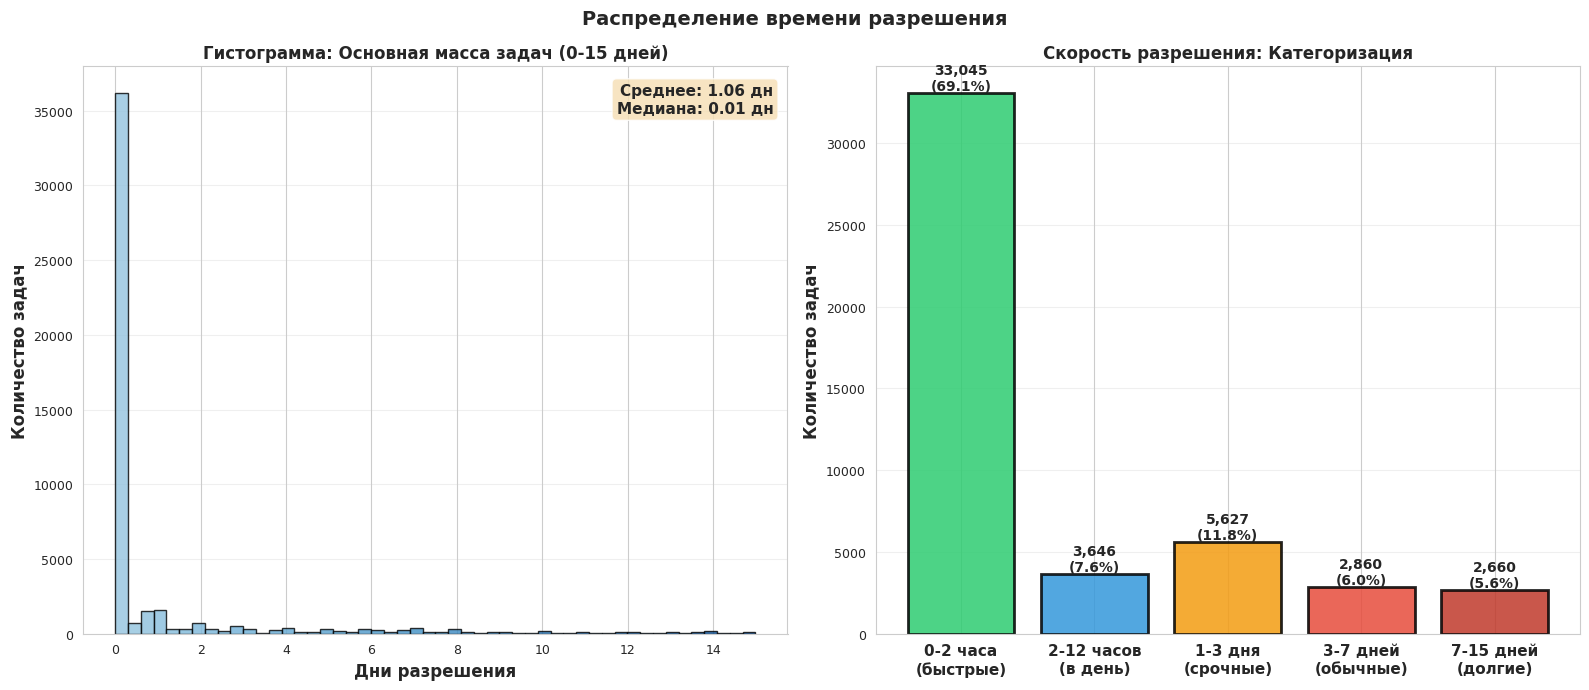

СТАТИСТИКА РАСПРЕДЕЛЕНИЯ (основная масса 0-15 дней):
  Основные метрики:
    ├─ Минимум:       0.0001 дней
    ├─ Медиана (P50): 0.0076 дней
    ├─ Среднее:       1.6259 дней
    ├─ P75:           0.5968 дней
    ├─ P90:           5.8380 дней
    └─ Максимум:      36.0228 дней

  Скорость разрешения:
0-2 часа
(быстрые)                      :  33,045 ( 69.1%)
2-12 часов
(в день)                     :   3,646 (  7.6%)
1-3 дня
(срочные)                       :   5,627 ( 11.8%)
3-7 дней
(обычные)                      :   2,860 (  6.0%)
7-15 дней
(долгие)                      :   2,660 (  5.6%)

  ВСЕГО (включая долгие > 15 дн):  49,183 задач
КЛЮЧЕВЫЕ ВЫВОДЫ:
  За 1 день решается: 79.4% всех задач
  За 3 дня решается: 86.0%
  За 7 дней решается: 91.9%
  За 15 дней решается: 97.3%
  Дольше 15 дней: 1,345 задач (2.7%)




In [65]:
print("\nРАСПРЕДЕЛЕНИЕ ВРЕМЕНИ РАЗРЕШЕНИЯ")

# Фильтруем только решённые тикеты с корректным временем
resolved_all = issues_clean[
    (issues_clean['resolved_dt'].notna()) &
    (issues_clean['days_to_resolve'] >= 0)
].copy()

# Для графика: 0-15 дней для лучшей видимости
resolved_vis = resolved_all[resolved_all['days_to_resolve'] <= 15].copy()

total_resolved = len(resolved_all)
on_vis = len(resolved_vis)
outliers = total_resolved - on_vis

print(f"Анализ распределения времени разрешения")
print(f"Решённых задач (всего): {total_resolved:,}")
print(f"На графике (0-15 дней): {on_vis:,} ({100*on_vis/total_resolved:.1f}%)")
print(f"Выбросы (> 15 дней): {outliers:,} ({100*outliers/total_resolved:.1f}%)\n")

fig, axes = plt.subplots(1, 2, figsize=(16, 7))
fig.suptitle('Распределение времени разрешения', fontsize=14, fontweight='bold')

# ========== ГРАФИК 1: Скошенное распределение - ТОЛЬКО СТОЛБЦЫ ==========
ax1 = axes[0]
counts, bins, patches = ax1.hist(resolved_vis['days_to_resolve'], bins=50,
                                  color='#3498db', alpha=0.8, edgecolor='black', linewidth=1)

# Окрашиваем столбцы градиентом
cm = plt.cm.Blues
for i, patch in enumerate(patches):
    patch.set_facecolor(cm(0.4 + 0.5 * (i / len(patches))))

ax1.set_xlabel('Дни разрешения', fontweight='bold', fontsize=12)
ax1.set_ylabel('Количество задач', fontweight='bold', fontsize=12)
ax1.set_title('Гистограмма: Основная масса задач (0-15 дней)', fontsize=12, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Добавляем статистику как текст
stats_text = f"Среднее: {resolved_vis['days_to_resolve'].mean():.2f} дн\nМедиана: {resolved_vis['days_to_resolve'].median():.2f} дн"
ax1.text(0.98, 0.97, stats_text, transform=ax1.transAxes,
        fontsize=11, verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8), fontweight='bold')

# ========== ГРАФИК 2: Категоризованные данные ==========
ax2 = axes[1]

# Категоризуем: правильно - 4 категории, 5 bins
# bins: [0, 2/24, 12/24, 3, 7, 15] - 5 точек = 4 интервала
categories_simple = ['0-2 часа\n(быстрые)', '2-12 часов\n(в день)',
                     '1-3 дня\n(срочные)', '3-7 дней\n(обычные)', '7-15 дней\n(долгие)']
bins_simple = [0, 2/24, 12/24, 3, 7, 15]

resolved_vis_cat = resolved_vis.copy()
resolved_vis_cat['category_simple'] = pd.cut(resolved_vis_cat['days_to_resolve'],
                                              bins=bins_simple,
                                              labels=categories_simple,
                                              include_lowest=True)

counts_simple = resolved_vis_cat['category_simple'].value_counts().sort_index()

colors_simple = ['#2ecc71', '#3498db', '#f39c12', '#e74c3c', '#c0392b']
bars = ax2.bar(range(len(counts_simple)), counts_simple.values,
               color=colors_simple, alpha=0.85, edgecolor='black', linewidth=2)

ax2.set_xticks(range(len(counts_simple)))
ax2.set_xticklabels(counts_simple.index, fontweight='bold', fontsize=11)
ax2.set_ylabel('Количество задач', fontweight='bold', fontsize=12)
ax2.set_title('Скорость разрешения: Категоризация', fontsize=12, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Добавляем значения и проценты
for bar, count in zip(bars, counts_simple.values):
    height = bar.get_height()
    pct = (count / len(resolved_vis_cat)) * 100
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(count):,}\n({pct:.1f}%)',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"СТАТИСТИКА РАСПРЕДЕЛЕНИЯ (основная масса 0-15 дней):")

print(f"  Основные метрики:")
print(f"    ├─ Минимум:       {resolved_all['days_to_resolve'].min():.4f} дней")
print(f"    ├─ Медиана (P50): {resolved_all['days_to_resolve'].median():.4f} дней")
print(f"    ├─ Среднее:       {resolved_all['days_to_resolve'].mean():.4f} дней")
print(f"    ├─ P75:           {resolved_all['days_to_resolve'].quantile(0.75):.4f} дней")
print(f"    ├─ P90:           {resolved_all['days_to_resolve'].quantile(0.90):.4f} дней")
print(f"    └─ Максимум:      {resolved_all['days_to_resolve'].max():.4f} дней")

print(f"\n  Скорость разрешения:")
for idx, (cat, count) in enumerate(counts_simple.items()):
    pct = (count / len(resolved_vis_cat)) * 100
    print(f"{str(cat):40s}: {count:>7,} ({pct:>5.1f}%)")

print(f"\n  ВСЕГО (включая долгие > 15 дн):  {total_resolved:,} задач")

# Вывод
fast_pct = ((resolved_all['days_to_resolve'] <= 1).sum() / total_resolved) * 100
print(f"КЛЮЧЕВЫЕ ВЫВОДЫ:")
print(f"  За 1 день решается: {fast_pct:.1f}% всех задач")
print(f"  За 3 дня решается: {((resolved_all['days_to_resolve'] <= 3).sum() / total_resolved * 100):.1f}%")
print(f"  За 7 дней решается: {((resolved_all['days_to_resolve'] <= 7).sum() / total_resolved * 100):.1f}%")
print(f"  За 15 дней решается: {((resolved_all['days_to_resolve'] <= 15).sum() / total_resolved * 100):.1f}%")
print(f"  Дольше 15 дней: {outliers:,} задач ({100*outliers/total_resolved:.1f}%)")
print(f"\n")

In [73]:
print("ФИНАЛЬНАЯ СВОДКА: KPI И КЛЮЧЕВЫЕ МЕТРИКИ")

# ========== ОБЩИЕ СТАТИСТИКИ ==========
total_issues = len(issues_clean)
resolved_issues = issues_clean[issues_clean['resolved_dt'].notna()]
open_issues = issues_clean[issues_clean['resolved_dt'].isna()]

resolved_count = len(resolved_issues)
open_count = len(open_issues)
resolution_rate = (resolved_count / total_issues) * 100

print(f"\nОБЩИЕ СТАТИСТИКИ:")
print(f"  Всего задач:              {total_issues:>10,}")
print(f"  Решённых задач:           {resolved_count:>10,} ({resolution_rate:>5.2f}%)")
print(f"  Открытых задач:           {open_count:>10,} ({100-resolution_rate:>5.2f}%)")

# ========== ВРЕМЯ РАЗРЕШЕНИЯ ==========
resolved_with_time = resolved_issues[
    (resolved_issues['days_to_resolve'] >= 0)
].copy()

avg_days = resolved_with_time['days_to_resolve'].mean()
median_days = resolved_with_time['days_to_resolve'].median()
p75_days = resolved_with_time['days_to_resolve'].quantile(0.75)
p90_days = resolved_with_time['days_to_resolve'].quantile(0.90)
p95_days = resolved_with_time['days_to_resolve'].quantile(0.95)

print(f"\nВРЕМЯ РАЗРЕШЕНИЯ (в днях):")
print(f"  Среднее (Mean):           {avg_days:>10.2f} дней")
print(f"  Медиана (P50):            {median_days:>10.4f} дней")
print(f"  75-й квартиль (P75):      {p75_days:>10.2f} дней")
print(f"  90-й квартиль (P90):      {p90_days:>10.2f} дней")
print(f"  95-й квартиль (P95):      {p95_days:>10.2f} дней")

# ========== SLA МЕТРИКИ ==========
sla_1day = ((resolved_with_time['days_to_resolve'] <= 1).sum() / len(resolved_with_time)) * 100
sla_3day = ((resolved_with_time['days_to_resolve'] <= 3).sum() / len(resolved_with_time)) * 100
sla_7day = ((resolved_with_time['days_to_resolve'] <= 7).sum() / len(resolved_with_time)) * 100
sla_14day = ((resolved_with_time['days_to_resolve'] <= 14).sum() / len(resolved_with_time)) * 100
sla_30day = ((resolved_with_time['days_to_resolve'] <= 30).sum() / len(resolved_with_time)) * 100

print(f"\nSLA МЕТРИКИ (% задач, решённых в срок):")
print(f"  За 1 день:                {sla_1day:>10.2f}%")
print(f"  За 3 дня:                 {sla_3day:>10.2f}%")
print(f"  За 7 дней:                {sla_7day:>10.2f}%")
print(f"  За 14 дней:               {sla_14day:>10.2f}%")
print(f"  За 30 дней:               {sla_30day:>10.2f}%")

# ========== ПО КАТЕГОРИЯМ ==========
print(f"\nРАСПРЕДЕЛЕНИЕ ПО КАТЕГОРИЯМ:")
print(f"{'Категория':20} | {'Кол-во':>10} | {'% всех':>8} | {'Решено %':>8} | {'Avg дн':>8}")

for category in sorted(issues_clean['category'].unique()):
    cat_all = issues_clean[issues_clean['category'] == category]
    cat_resolved = cat_all[cat_all['resolved_dt'].notna()]
    cat_count = len(cat_all)
    cat_pct = (cat_count / total_issues) * 100
    cat_res_pct = (len(cat_resolved) / cat_count) * 100 if cat_count > 0 else 0
    cat_avg_days = cat_resolved[cat_resolved['days_to_resolve'] >= 0]['days_to_resolve'].mean() if len(cat_resolved) > 0 else 0

    print(f"{category:20} | {cat_count:>10,} | {cat_pct:>7.1f}% | {cat_res_pct:>7.1f}% | {cat_avg_days:>7.2f}")

# ========== BACKLOG И ДОЛГИЕ ЗАДАЧИ ==========
print(f"\nBACKLOG И КРИТИЧЕСКИЕ МЕТРИКИ:")

# Долгие решённые
long_30 = ((resolved_with_time['days_to_resolve'] > 30).sum() / len(resolved_with_time)) * 100
long_90 = ((resolved_with_time['days_to_resolve'] > 90).sum() / len(resolved_with_time)) * 100

# Старые открытые
reference_date = issues_clean['created_dt'].max()
open_issues_copy = open_issues.copy()
open_issues_copy['age_days'] = (reference_date - open_issues_copy['created_dt']).dt.days
old_open_30 = ((open_issues_copy['age_days'] > 30).sum() / open_count) * 100 if open_count > 0 else 0
old_open_90 = ((open_issues_copy['age_days'] > 90).sum() / open_count) * 100 if open_count > 0 else 0

print(f"  Решённые дольше 30 дней:  {long_30:>10.2f}%")
print(f"  Решённые дольше 90 дней:  {long_90:>10.2f}%")
print(f"  Открытые старше 30 дней:  {old_open_30:>10.2f}%")
print(f"  Открытые старше 90 дней:  {old_open_90:>10.2f}%")

# ========== ПАТТЕРНЫ ==========
print(f"\nПАТТЕРНЫ СОЗДАНИЯ ЗАДАЧ:")

weekday_count = issues_clean[issues_clean['created_dt'].dt.dayofweek < 5].shape[0]
weekend_count = issues_clean[issues_clean['created_dt'].dt.dayofweek >= 5].shape[0]

print(f"  Рабочие дни (Пн-Пт):      {weekday_count:>10,} ({(weekday_count/total_issues)*100:>6.2f}%)")
print(f"  Выходные (Сб-Вс):         {weekend_count:>10,} ({(weekend_count/total_issues)*100:>6.2f}%)")
if weekend_count > 0:
    print(f"  Соотношение:              {weekday_count/weekend_count:>10.2f}x")

# ========== ВЫВОДЫ ==========
print(f"\nКЛЮЧЕВЫЕ ВЫВОДЫ:")

if resolution_rate > 95:
    print(f"  Отличный уровень разрешения: {resolution_rate:.1f}%")
elif resolution_rate > 90:
    print(f"  Хороший уровень разрешения: {resolution_rate:.1f}%")
else:
    print(f"  Требует улучшения разрешение: {resolution_rate:.1f}%")

if median_days < 1:
    print(f"  Отличная скорость (медиана < 1 дня)")
elif median_days < 7:
    print(f"  Хорошая скорость (медиана {median_days:.2f} дней)")
else:
    print(f"  Медленное разрешение (медиана {median_days:.2f} дней)")

if sla_30day > 95:
    print(f"  Отличное SLA за 30 дней: {sla_30day:.1f}%")
elif sla_30day > 85:
    print(f"  Хорошее SLA за 30 дней: {sla_30day:.1f}%")
else:
    print(f"  Требует улучшения SLA: {sla_30day:.1f}%")

if old_open_90 < 5:
    print(f"  Минимум старых открытых задач: {old_open_90:.1f}%")
else:
    print(f"  Много старых открытых задач: {old_open_90:.1f}% (требует очистки)")

# ========== ТАБЛИЦА-СВОДКА ==========
print(f"\nТАБЛИЦА-СВОДКА ВСЕХ KPI:")
print(f"{'Метрика':<40} | {'Значение':>15}")
print(f"{'Всего задач':<40} | {total_issues:>15,}")
print(f"{'Уровень разрешения':<40} | {resolution_rate:>14.2f}%")
print(f"{'Среднее время разрешения':<40} | {avg_days:>14.2f} дн")
print(f"{'Медиана времени разрешения':<40} | {median_days:>14.4f} дн")
print(f"{'P95 время разрешения':<40} | {p95_days:>14.2f} дн")
print(f"{'SLA за 1 день':<40} | {sla_1day:>14.2f}%")
print(f"{'SLA за 7 дней':<40} | {sla_7day:>14.2f}%")
print(f"{'SLA за 30 дней':<40} | {sla_30day:>14.2f}%")
print(f"{'Открытые задачи':<40} | {open_count:>15,}")
print(f"{'Открытые старше 90 дней':<40} | {old_open_90:>14.2f}%")
print(f"{'Рабочие дни (% от всех)':<40} | {(weekday_count/total_issues)*100:>14.2f}%")

ФИНАЛЬНАЯ СВОДКА: KPI И КЛЮЧЕВЫЕ МЕТРИКИ

ОБЩИЕ СТАТИСТИКИ:
  Всего задач:                  51,950
  Решённых задач:               49,183 (94.67%)
  Открытых задач:                2,767 ( 5.33%)

ВРЕМЯ РАЗРЕШЕНИЯ (в днях):
  Среднее (Mean):                 1.63 дней
  Медиана (P50):                0.0076 дней
  75-й квартиль (P75):            0.60 дней
  90-й квартиль (P90):            5.84 дней
  95-й квартиль (P95):           10.84 дней

SLA МЕТРИКИ (% задач, решённых в срок):
  За 1 день:                     79.45%
  За 3 дня:                      86.04%
  За 7 дней:                     91.86%
  За 14 дней:                    96.76%
  За 30 дней:                    99.80%

РАСПРЕДЕЛЕНИЕ ПО КАТЕГОРИЯМ:
Категория            |     Кол-во |   % всех | Решено % |   Avg дн
Local                |     26,366 |    50.8% |    94.7% |    1.64
New User             |      6,144 |    11.8% |    94.7% |    1.60
Remote               |     18,167 |    35.0% |    94.2% |    1.73
Software License     